In [1]:
# %load scikit-image/doc/examples/transform/plot_ring_detector.py
"""
=============================
Ridge Directed Ring Detection
=============================

Robust and highly performant ring detection algorithm for 3D particle tracking
using 2D microscopy imaging.

Here's a quick description of the parameters. The explanations refer to the
terms as introduced in [Afik 2015](https://www.nature.com/articles/srep13584)
and its Supplementary Information.

`sigma` is the width of the Gaussian Kernel to smooth the image; a typical
good value should be the width (measured in pixels) of the ridge you would
like to detect (to clarify, this is not the radius of the ring but the
thickness of the curve).

`ksize` is the size of the [Sobel kernel](
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html?highlight=sobel)
to estimate the image spatial derivatives (the default should work in most
cases)

`curv_thresh` this sets a threshold for preliminary search for ridges; pixels
of least [principal curvature](
https://en.wikipedia.org/wiki/Principal_curvature) (the smaller value of the
two eigenvalues of the [Hessian](
https://en.wikipedia.org/wiki/Hessian_matrix) applied to the image) _larger_
than `curv_thresh` would not be considered. This can be used to spare
unnecessary calculations (speed-up) and avoid ridges which are too flat (
reduce noise). [Fig. 2b](https://www.nature.com/articles/srep13584#f2) shows
the output which is affected by `sigma`, `ksize` and `curv_thresh`.

`Rmin`
 smallest radius to consider in the search for circles (measured in pixels)

`Rmax`
 largest radius to consider in the search for circles (measured in pixels)

`vote_thresh` this sets a threshold for preliminary search for circle
candidates in the parameter (Hough) space; see [Fig. 2c](
https://www.nature.com/articles/srep13584#f2). Elements with vote count
_smaller_ than `vote_thresh` would not be examined. This can be used to spare
unnecessary calculations (speed-up).

`circle_thresh` this sets a threshold to filter detected circle candidates;
ideally one would expect a circle to have 2 * pi * `r` votes per circle of
radius `r`; given image quality and the optimisation of the parameters
applied in earlier stages, one may like to be satisfied with a fraction of a
circle. `circle_thresh` should be a value between 0 and 2*pi; note that the
radius `r` should not be included; e.g. for 50% of the circumference one
should set `circle_thresh = pi` (for `pi = np.pi` or roughly `3.14`). Circle
candidates with vote count smaller than `circle_thresh` would be discarded.
See [Figure 2d](https://www.nature.com/articles/srep13584#f2).

`dr` as part of sub-pixel evaluation, a best fit is being applied to the
detected ridges. To include ridge pixels which are expected to belong to the
candidate circle, an annulus mask of thickness `dr` (measured in pixels) is
created, based on the circle parameters found in earlier stages in the
algorithm. See the example in [Fig. 2e](
https://www.nature.com/articles/srep13584#f2).

`eccentricity` if `eccentricity` is non-zero, a fit to ellipse will be
applied, instead of a circle; this is far from optimal.

Acknowledgements would be highly appreciated; for academic citation please use:

Afik, E. [Robust and highly performant ring detection algorithm for 3d
particle tracking using 2d microscope imaging](
https://www.nature.com/articles/srep13584). Sci. Rep. 5, 13584; doi:
10.1038/srep13584 (2015).

"""

import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import ring_detector
from skimage import data
from scipy import ndimage

image = data.coins()[0:95, 70:370]

# As the algorithm is currently meant for ridges, convert the image to a
# gradient magnitude image
image = image.astype(np.float32)
sigma = .5
image_gradient_magnitude = ndimage.gaussian_gradient_magnitude(image, sigma)


# Helper function to plot the rings
def plot_rings(xyr, minrad=1, ring_colour='g',
               ring_style=[None, 'dotted', 'dashed'][0], lw=1, txt_colour='r'):
    """
    given a 3-column array of (x,y) for ring centres & a radius, plots the
    rings
    """
    for c in xyr:
        if c[-1] > minrad:
            circle = plt.Circle(c[:2][::-1], c[-1], ec=ring_colour, fill=False,
                                lw=lw, ls=ring_style)
            plt.gca().add_patch(circle)
            i, j, r = c
            if txt_colour:
                plt.text(j, i, '.', fontsize=20, color=txt_colour)
    plt.draw()

In [11]:
%%time
# %%timeit

# Detect Rings
ridge_hough = ring_detector.RidgeHoughTransform(image_gradient_magnitude)
ridge_hough.params['sigma'] = 3
ridge_hough.params['Rmin'] = 15
ridge_hough.params['Rmax'] = 30
ridge_hough.params['curv_thresh'] = -.35
ridge_hough.params['circle_thresh'] = .4 * 2 * np.pi
ridge_hough.params['vote_thresh'] = 3
ridge_hough.params['dr'] = 3
ridge_hough.img_preprocess()
ridge_hough.rings_detection()
cht_rings = ridge_hough.output['rings_subpxl']

14 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


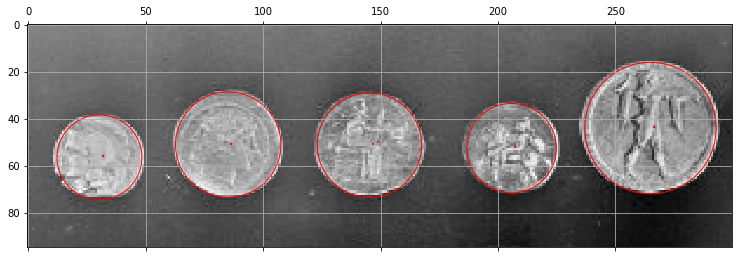

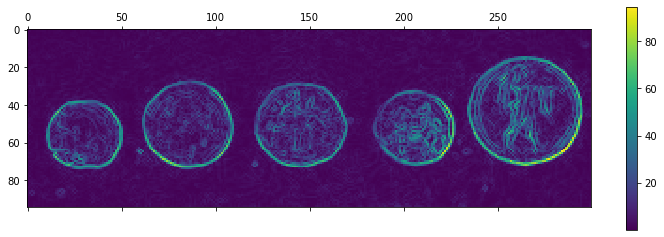

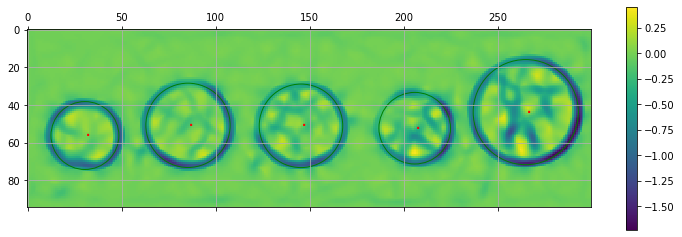

In [7]:
plt.matshow(image, cmap=plt.cm.gray)
plot_rings(cht_rings, ring_colour='r')
plt.grid(True)

# Show the Gradient Magnitude Field
plt.matshow(image_gradient_magnitude)
plt.colorbar()

# Show the Least Principle Curvature Field
plt.matshow(np.asarray(ridge_hough.deriv['principal_curv']))
plt.colorbar()
plot_rings(cht_rings)
plt.grid(True)

In [8]:
cht_rings

array([[ 56.2216  ,  30.34456 ,  18.064808],
       [ 52.321293, 205.81056 ,  19.04646 ],
       [ 50.795765,  85.178276,  22.424511],
       [ 51.055904, 145.29063 ,  22.216112],
       [ 43.766006, 264.88116 ,  27.968548]], dtype=float32)